In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import genfromtxt
from scipy.stats import gamma, uniform

In [104]:
disasters = genfromtxt('disasters.csv', delimiter = ',')

def 

#Calculate transition probability, based on random walk proposal
def calc_probability_random_walk(tau, breakpoints_current, breakpoints_propose, labda):
    
    # Check if sorted
    if np.all(breakpoints_propose[:-1] <= breakpoints_propose[1:]):
        
        nt_current = np.histogram(tau, bins = breakpoints_current)[0].astype('int32')
        nt_propose = np.histogram(tau, bins = breakpoints_propose)[0].astype('int32')
        
        log_prob_current = (np.sum(np.log(np.diff(breakpoints_current))) 
                            - np.sum(lambdas*np.diff(breakpoints_current)) 
                            + np.sum(nt_current*np.log(labda)))
        
        log_prob_propose = (np.sum(np.log(np.diff(breakpoints_propose)))
                            -np.sum(lambdas*np.diff(breakpoints_propose)) 
                            + np.sum(nt_propose*np.log(labda)))
               
        return np.exp(log_prob_propose - log_prob_current)
    
    else:
        return 0 
    
#Propose moving one single breakpoint
def proposal_random_walk(breakpoints, index, rho):
    
    ti = breakpoints[index]
    R = rho*(breakpoints[index+1] - breakpoints[index-1])
    epsilon = np.random.uniform(-R, R)
    ti_proposal = ti + epsilon

    breakpoints_propose = np.copy(breakpoints)
    breakpoints_propose[index] = ti_proposal
    
    return breakpoints_propose

def sample_lambdas(tau, theta, breakpoints, num_breakpoints):
    
    nt_current = np.histogram(tau, bins = breakpoints)[0].astype('int32')
    diff = np.diff(breakpoints)
    
    sample_lambda = lambda i: gamma.rvs(2 + nt_current[i], theta + diff[i], 1)
    
    lambdas = np.apply_along_axis(sample_lambda, 0, np.arange(0, num_breakpoints + 1))
    
    return lambdas
    
def sample_theta(psi, labdas, num_breakpoints):
    
    theta = gamma.rvs(2 + 2*(num_breakpoints + 1), psi + np.sum(labdas))
    
    return theta
    
    
def init_mcmc(N, num_breakpoints, psi, rho, burn_in = 0, print_debug = False):
    
    #Initial burn in attempts if needed
    M = N + burn_in
    
    #Initialize arrays
    breakpoints = np.zeros((M, num_breakpoints + 2))
    breakpoints[0] = np.arange(1658,1981, (1980-1658)/(num_breakpoints+1))
    tau = disasters  

    #Arrays to save values of lambda and theta
    lambdas = np.zeros((M, num_breakpoints + 1))
    thetas = np.zeros(M)
    
    #Array to save MH probability
    probs = np.zeros(M)
    
    #Initialize theta and lambda by prior distribution
    thetas[0] = gamma.rvs(2, psi, 1)
    
    for interval in range(num_breakpoints + 1):
        lambdas[0, interval] = gamma(2, thetas[0]).rvs(1)
    
    #Main loop
    for index in range(M - 1):
        
        #Gibbs sampling
        thetas[index + 1] = sample_theta(psi, lambdas[index], num_breakpoints)
        lambdas[index + 1] = sample_lambdas(tau, thetas[index + 1], breakpoints[index], num_breakpoints)
        
            
        if print_debug:
            print(f'Iter: {index}')
            print(f' Theta: {thetas[index]}')
            print(f' Lambda: {lambdas[index]}')
        
        
        #Random walk proposal for breakpoints (MH Sampling)
        breakpoints_propose = np.copy(breakpoints[index])
        
        #Propose one breakpoint at a time
        for t in np.arange(num_breakpoints) + 1:
            
            #Propose new breakpoint
            breakpoints_propose = proposal_random_walk(breakpoints_propose, t, rho)

        #Probability of accept
        probs[index] = calc_probability_random_walk(tau, breakpoints[index], breakpoints_propose, lambdas[index + 1])

        accept = np.random.uniform(0,1) < probs[index]

        if print_debug:
            print(f'Breakpoint {t}')
            print(f' Current breakpoints: {breakpoints[index]}')
            print(f' Proposed breakpoints: {breakpoints_propose}')
            print(f' P(accept) = {probs[index]}')
            print(f' Accept: {accept}')

        if accept:
            breakpoints[index + 1] = np.copy(breakpoints_propose)
        else:
            breakpoints[index+1] = np.copy(breakpoints[index])

    return breakpoints, lambdas, probs
    

Iter: 0
 Theta: 2.2581470230607383
 Lambda: [4.552839   3.39606362 3.49849049]
Breakpoint 2
 Current breakpoints: [1658.         1765.33333333 1872.66666667 1980.        ]
 Proposed breakpoints: [1658.         1702.4790416  1815.76004821 1980.        ]
 P(accept) = 1.0
 Accept: True
Iter: 1
 Theta: 24.00309273456307
 Lambda: [150.16874263 548.9724181  465.86995576]
Breakpoint 2
 Current breakpoints: [1658.         1702.4790416  1815.76004821 1980.        ]
 Proposed breakpoints: [1658.         1758.91761287 1841.1075119  1980.        ]
 P(accept) = 1.0
 Accept: True
Iter: 2
 Theta: 1171.7088981707398
 Lambda: [1219.93203301 1350.253133   2006.71047821]
Breakpoint 2
 Current breakpoints: [1658.         1758.91761287 1841.1075119  1980.        ]
 Proposed breakpoints: [1658.         1676.90751789 1714.27459409 1980.        ]
 P(accept) = 1.0
 Accept: True
Iter: 3
 Theta: 4589.180786835637
 Lambda: [4697.24858757 4811.52912442 5280.8350865 ]
Breakpoint 2
 Current breakpoints: [1658.      

<ipython-input-104-f437353692e0>:20: RuntimeWarning: overflow encountered in exp
  return np.exp(log_prob_propose - log_prob_current)


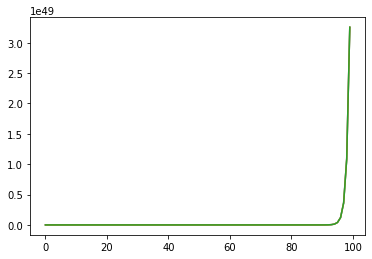

In [108]:
breakpoints, lambdas, probs = init_mcmc(N = 100, num_breakpoints = 2, psi = 1, rho = 0.5, print_debug = True)
plt.plot(lambdas)

In [60]:
np.histogram(disasters, bins = 'auto')

(array([ 1,  0,  0,  0,  2,  0,  1,  3,  0,  6,  7,  4, 14, 16, 25, 24, 47,
        80, 88, 98, 81, 57, 44, 44, 25, 31, 21, 14, 11,  7]),
 array([1658.4       , 1669.09333333, 1679.78666667, 1690.48      ,
        1701.17333333, 1711.86666667, 1722.56      , 1733.25333333,
        1743.94666667, 1754.64      , 1765.33333333, 1776.02666667,
        1786.72      , 1797.41333333, 1808.10666667, 1818.8       ,
        1829.49333333, 1840.18666667, 1850.88      , 1861.57333333,
        1872.26666667, 1882.96      , 1893.65333333, 1904.34666667,
        1915.04      , 1925.73333333, 1936.42666667, 1947.12      ,
        1957.81333333, 1968.50666667, 1979.2       ]))

In [23]:
array = np.array([1,4,2,2])

In [33]:
gamma = 1

In [34]:
gamma.rvs()

AttributeError: 'int' object has no attribute 'rvs'

In [94]:
a = np.array([1, 2, 3, 4, 5])

a1 = a[1:]
a2 = a[:-1]

In [95]:
np.all(a2 >= a1)

False

In [ ]:
a2